In [1]:
# Hyperparameters
test_results = True
T = 15
N = 10
n_from_index = 0 # How distant the first point is

In [2]:
import gym_duckietown
import matplotlib.pyplot as plt
import numpy as np

from gym_duckietown.simulator import Simulator
from casadi import *

import utils
from utils import get_trajectory, get_position, my_odometry


DEBUG:commons:version: 6.2.4 *
DEBUG:typing:version: 6.2.3
DEBUG:duckietown_world:duckietown-world version 6.2.38 path /home/giulio/prog/.virtualenvs/RACE/lib/python3.8/site-packages
DEBUG:geometry:PyGeometry-z6 version 2.1.4 path /home/giulio/prog/.virtualenvs/RACE/lib/python3.8/site-packages
DEBUG:aido_schemas:aido-protocols version 6.0.59 path /home/giulio/prog/.virtualenvs/RACE/lib/python3.8/site-packages
DEBUG:nodes:version 6.2.13 path /home/giulio/prog/.virtualenvs/RACE/lib/python3.8/site-packages pyparsing 3.0.6
DEBUG:gym-duckietown:gym-duckietown version 6.1.30 path /home/giulio/prog/.virtualenvs/RACE/lib/python3.8/site-packages



{'audio': ('xaudio2', 'directsound', 'openal', 'pulse', 'silent'), 'debug_font': False, 'debug_gl': True, 'debug_gl_trace': False, 'debug_gl_trace_args': False, 'debug_graphics_batch': False, 'debug_lib': False, 'debug_media': False, 'debug_texture': False, 'debug_trace': False, 'debug_trace_args': False, 'debug_trace_depth': 1, 'debug_trace_flush': True, 'debug_win32': False, 'debug_x11': False, 'graphics_vbo': True, 'shadow_window': True, 'vsync': None, 'xsync': True, 'xlib_fullscreen_override_redirect': False, 'darwin_cocoa': True, 'search_local_libs': True, 'advanced_font_features': False, 'headless': False, 'headless_device': 0}


In [3]:
plt.rcParams['figure.figsize'] = [7, 7]

In [4]:
#gym_duckietown is very chatty
import logging
gym_duckietown.logger.setLevel(logging.WARNING)

In [5]:
env = Simulator("ETH_large_loop",
    full_transparency=True,
    domain_rand=False,
    user_tile_start=[3,1],
    seed=42,
    max_steps=float("inf"),
    robot_speed=1.0,
)

INFO:duckietown_world: data: /home/giulio/prog/.virtualenvs/RACE/lib/python3.8/site-packages/duckietown_world/data


In [6]:
env.unwrapped.start_pose = [[0.11699990272521976, 0, 0.41029359288296474], pi/2]

In [7]:
dt = 1.0 / env.frame_rate

In [8]:
env.reset()
traj = get_trajectory(env, samples=500, method="distance", last_value_distance=1, sortby="angle")

/home/giulio/prog/duckrace_simulator/utils.py:279: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  points_fitted = np.vstack( spl(alpha) for spl in splines ).T


In [9]:
pose = get_position(env)
pose

Position(x=1.8719999027252197, y=1.9297064071170351, theta=1.5707963267948966)

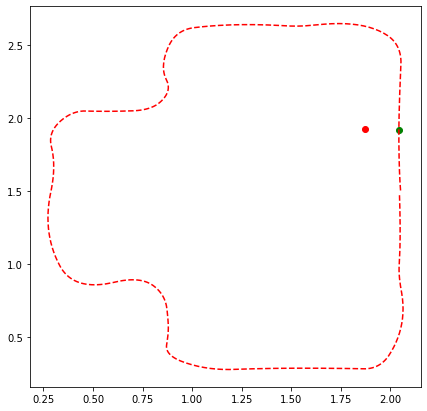

In [10]:
from scipy import spatial
distance,index = spatial.KDTree(traj).query([pose.x, pose.y])
index += n_from_index
plt.plot(*traj.T, "r--")
plt.scatter(pose.x, pose.y, c="r")
plt.scatter(traj[index,0], traj[index,1], c="g")

In [11]:
f"Samples must be at least: {np.round(np.sum( np.sqrt(np.sum( np.diff(traj, axis=0)**2, axis=1 )) ) / (0.6*dt))}"

'Samples must be at least: 378.0'

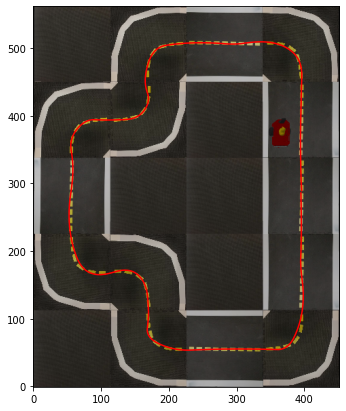

In [12]:
utils.show_on_map_array(env, traj[:,:2])

In [13]:
get_position(env)

Position(x=1.8719999027252197, y=1.9297064071170351, theta=1.5707963267948966)

In [14]:
# Compute the angle between every consecutive points in traj
angles = np.zeros(traj.shape[0])
for i in range(traj.shape[0]-1):
    angles[i] = np.arctan2(traj[i+1,1]-traj[i,1], traj[i+1,0]-traj[i,0])
angles[-1] = np.arctan2(traj[0,1]-traj[-1,1], traj[0,0]-traj[-1,0])

In [15]:
# Add angles to traj
traj = np.concatenate((traj, angles.reshape(-1,1)), axis=1)

In [16]:
# Drop values to fix weird final angle
traj = traj[1:-1]

Plot angles:

If faces right red, else blue

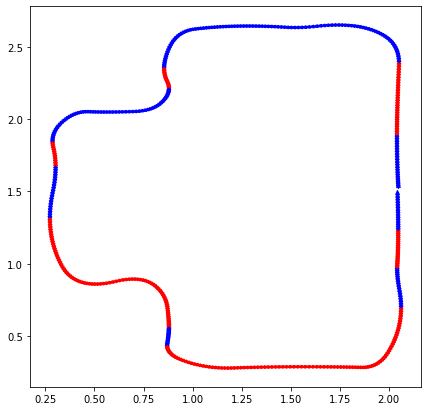

In [17]:
c="r"
for x, y, t in traj:
    dx = 0.007*np.cos(t)
    if x+dx < x:
        c = "b"
    else:
        c = "r"
    plt.arrow(x, y, dx, 0.008*np.sin(t), color=c, head_width=0.02)

In [18]:
traj[index]

array([2.04293693, 1.93920897, 1.55648403])

In [19]:
index = DM(index)
traj = DM(traj)

Initialize states, inputs, and system dynamic equation

In [20]:
up = 5
wp = 4
# parameters for forced dynamics
u_alpha_r = 1.5
u_alpha_l = 1.5
w_alpha_r = 15  # modify this for trim
w_alpha_l = 15

In [21]:
pose = get_position(env)

DAE

In [22]:
# States
x0 = MX.sym('x')
y0 = MX.sym('y')
th0 = MX.sym('th')
v0 = MX.sym('v')
w0 = MX.sym('w')
x = vertcat(x0, y0, th0, v0, w0) # Always vertically concatenate the states --> [n_x,1]
# Inputs
wl = MX.sym('wl')
wr = MX.sym('wr')
u = vertcat(wl, wr) # Always vertically concatenate the inputs --> [n_u,1]
# System dynamics (CAN BE NONLINEAR! ;))
# x_long_dot_dot = -u1*v0 + u_alpha_r*wr + u_alpha_l*wl
# w_dot_dot = -w1*w0 + w_alpha_r*wr - w_alpha_l*wl
v1 = (1-up*dt)*v0 + u_alpha_r*dt*wr + u_alpha_l*dt*wl
w1 = (1-wp*dt)*w0 + w_alpha_r*dt*wr - w_alpha_l*dt*wl
x1 = x0 + v0*dt*np.cos(th0 + w0*dt/2)
y1 = y0 + v0*dt*np.sin(th0 + w0*dt/2)
# Cannot use atan2 because x1 and y1 are approximated while th1 is not
theta1 = th0 + w0*dt
dae = vertcat(x1, y1, theta1, v1, w1)
F = Function('F',[x,u],[dae],['x','u'],['dae'])
if test_results:
    print(F([pose.x, pose.y, pose.theta, 0, 0], [1, 1]))

[1.872, 1.92971, 1.5708, 0.1, 0]


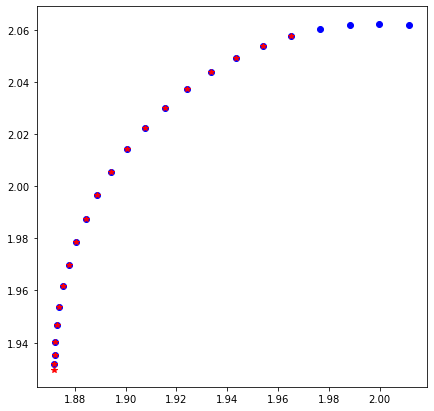

In [23]:
N_test=20
# Test the problem definition
sim = F.mapaccum(N_test) # To call the F function N times
x0 = [pose.x, pose.y, pose.theta, 0, 0]

res = sim(x0, [1, 0.2])
fig = plt.figure()
tgrid = np.linspace(0,T,N)
# plt.plot(tgrid, np.column_stack((x0, res)).T)
plt.plot(res[0, :], res[1, :], 'r*')
env.reset()
for action in [[1, 0.2]]*(N_test+3):
    obs, reward, done, info = env.step(action)
    p = get_position(env)
    plt.scatter(p.x, p.y, c='b')
_ = env.reset()

In [24]:
delay = round(0.15/dt)
u_delay0 = DM(np.zeros((2, delay)))
# N += delay

# Initial reference point
r0 = repmat(traj[index, :2].T, 1, N+1)
# Initial reference angles
t0 = repmat(traj[index, 2].T, 1, N+1)

# With preview
# Initial reference point
r0 = traj[index:index+N+1, :2].T
t0 = traj[index:index+N+1, 2].T

In [25]:
def mod(n, base):
    return n - floor(n/base) * base

In [46]:
opti = Opti()

x = opti.variable(5,N+1)    # States with dimension (n_x, prediction_horizon+1) (x(0),...,x(N+1))
u = opti.variable(2,N)#-delay)      # Inputs with dimension (n_u, prediction_horizon) (u(0),...,u(N))
p = opti.parameter(5,1)     # Parameter to set the initial state conditions (x(0))
r = opti.parameter(2,N+1)   # Parameter to set the initial index
tr = opti.parameter(1,N+1)   # Parameter to set the initial reference angles
u_delay = opti.parameter(2,delay) # Parameter to set the delay

# With delay:
# Q, Q2, R = 1, 1e-4, 1e-4
Q, Q2, R = 80, 5e-4, 1e-3
obj = Q*sumsqr(x[:2, :]-r) + Q2*sumsqr(mod(x[2, :]-tr+pi, 2*pi)-pi) + R*sumsqr(u)
# atan method is faster than mod (20s vs 23s on 1000 iterations) but it allows car to go backward
# obj = Q*sumsqr(x[:2, :]-r) + Q2*sumsqr(atan2(sin(x[2, :]-tr), cos(x[2, :]-tr))) + R*sumsqr(u)

opti.minimize(obj)          # Setup the problem 

# Constraints Definition

# 1) System dynamics constraint over the prediction horizon
for k in range(0,N):
   # opti.subject_to(x[:,k+1]==F(x[:,k],horzcat(u_delay, u)[:, k])) # Horzacat to include delay
   opti.subject_to(x[:,k+1]==F(x[:,k],u[:,k])) # No delay
    
# 2) Additional states/inputs constraints 
opti.subject_to(vec(u) <= 1)
opti.subject_to(vec(u) >= -1)
# 3) Force the state variable at instant 0 to be equal to the parameter value containing x0 value
opti.subject_to(x[:,0] == p)

opti.set_value(p,[pose.x, pose.y, pose.theta, 0, 0]) # Set the initial x0 value
opti.set_value(r,r0) # Set the initial reference points
opti.set_value(tr,t0) # Set the initial reference angles
opti.set_value(u_delay, u_delay0) # Initial delay

# Ipopt
opts = dict()
opts["ipopt.print_level"] = 0
opts["print_time"] = False
opti.solver('ipopt',opts)

# Test over 1 time horizon
if test_results:
    sol = opti.solve()

In [47]:
# This instruction transfom all the Opti problem defined above into a callable function
M = opti.to_function('M',[p, r, tr, u_delay],[u[:,0]],['p', 'r', 'tr', 'u_delay'],['u_opt'])

In [48]:
# MPC loop
X_log = np.empty((5,0))
U_log = np.empty((2,0))

x = [pose.x, pose.y, pose.theta, 0, 0]
r = r0
tr = t0
idx = index
u_delay = u_delay0
errors = []

kdtree = spatial.KDTree(traj[:, :2])

for i in range(450):
    u = M(x, r, tr, u_delay)

    U_log = np.column_stack((U_log, u))
    X_log = np.column_stack((X_log, x))

    u_delay = np.column_stack((u_delay, u))[:, -delay:]

    # simulate
    x = F(x,u)

    distance = (traj[idx, 0] - x[0])**2 + (traj[idx, 1] - x[1])**2
    errors.append(distance)

    _,idx = kdtree.query(np.array([x[0], x[1]]).reshape(-1))
    r = traj[idx:idx+N+1, :2].T
    tr = traj[idx:idx+N+1, 2].T

In [49]:
f"Max reached speed: {X_log[3,:].max()}, max speed is 0.6"

'Max reached speed: 0.5776368741843436, max speed is 0.6'

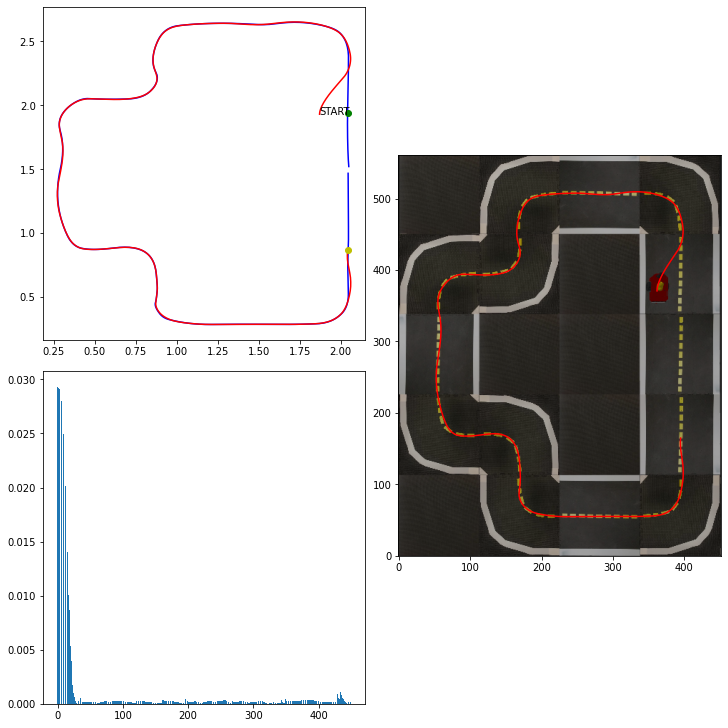

In [50]:
fig = plt.figure(constrained_layout=True, figsize=(10, 10))
ax_dict = fig.subplot_mosaic("""AC
        BC""")
ax_dict["A"].text(X_log[0,0], X_log[1,0], 'START')
ax_dict["A"].plot(traj[:,0], traj[:,1], "b")
ax_dict["A"].plot(traj[index,0], traj[index,1], 'go')
ax_dict["A"].plot(X_log[0,:], X_log[1,:], "r")
ax_dict["A"].plot(traj[idx, 0], traj[idx,1], 'yo')
errors = np.array(errors).reshape(-1)
ax_dict["B"].bar(range(len(errors)), errors)
utils.show_on_map_array(env, np.array([X_log[0,:], X_log[1,:]]).T, fig=ax_dict["C"])

If you want to save the MPC controller, i.e. the M function for later use, you can do it!

In [51]:
M.save('M.casadi')
M2 = Function.load('M.casadi')
DM.set_precision(15)
print(M(x0, r0, t0, u_delay0))
print(M2(x0, r0, t0, u_delay0))

[1.00000000243106, 0.572472328566152]
[1.00000000243106, 0.572472328566152]


### Gym simulation

The MPC does not consider the delay yet!

In [42]:
record = True

if record:
    import imageio
    import cv2

    env.reset()
    pose = get_position(env)
    images = []
    positions = []
    odoms = [pose]
    actions = [[0,0]]*10
    v0 = 0
    w0 = 0
    for action in U_log.T:
        env.step(action)
        positions.append(get_position(env))
        img = env.render(mode='rgb_array')
        img = cv2.resize(img, dsize=(400, 300), interpolation=cv2.INTER_CUBIC)
        images.append(img)

        p, v0, w0 = my_odometry(action, odoms[-1].x, odoms[-1].y, odoms[-1].theta, v0, w0, dt=dt)
        odoms.append(p)
        actions.append(action)

    imageio.mimsave("assets/mpc_run.gif", images, format='GIF', fps=env.frame_rate)

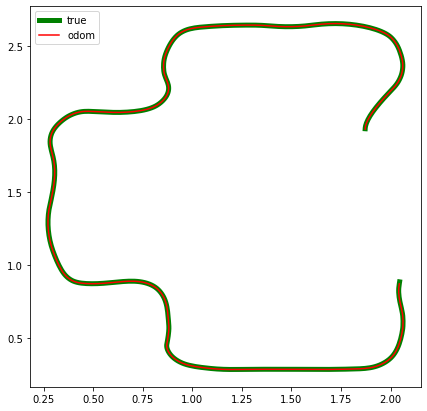

In [43]:
if record:
    plt.plot(*np.array([[p.x, p.y] for p in positions]).T, c='g', label='true', linewidth=5)
    plt.plot(*np.array([[p.x, p.y] for p in odoms]).T, c='r', label='odom')
    plt.legend()

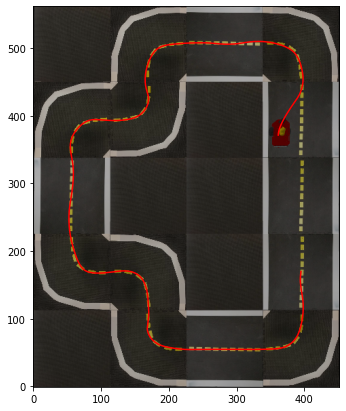

In [44]:
if record:
    utils.show_on_map(env, positions)

In [45]:
from IPython.display import HTML, display
# Trick to prevent cache use
display(HTML('<img src="assets/mpc_run.gif?%d" width="750" align="center">' % np.random.randint(10)))